### 📌 Project Overview

This project performs an exploratory data analysis (EDA) on Google Play Store apps
to understand app characteristics, popularity patterns, pricing behavior, and
factors influencing app success.  

The analysis covers:
- Data cleaning and preprocessing
- Univariate, bivariate, and multivariate analysis
- User review sentiment analysis
- Cross-dataset insights by merging apps and reviews data


## 🔍 Initial Data Inspection

Before cleaning the dataset, we first examine its basic structure, size, missing values,
duplicates, and key columns. This helps identify potential data quality issues that need
to be addressed before analysis.


In [1]:
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Loading_dataset
df = pd.read_csv("../data/apps_data.csv")

# Dataset shape
df.shape

# Dataset structure and data types
df.info()

# Column names
df.columns

# Missing values in each column
df.isnull().sum()

# Check duplicate rows
df.duplicated().sum()

# Count apps with size listed as 'Varies with device'
(df["Size"] == "Varies with device").sum()

# Most common Size values
df["Size"].value_counts().head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Size
Varies with device    1695
11M                    198
12M                    196
14M                    194
13M                    191
15M                    184
17M                    160
19M                    154
26M                    149
16M                    149
25M                    143
20M                    139
21M                    138
10M                    136
24M                    136
18M                    133
23M                    117
22M                    114
29M                    103
27M                     97
Name: count, dtype: int64

## 🧹 Duplicate & Missing Value Handling

We begin data cleaning by checking for missing values and duplicate records.
Duplicate rows are removed to avoid biased analysis, and the index is reset
to maintain consistency.


In [ ]:
# Check missing values
df.isnull().sum()

# Check duplicates
df.duplicated().sum()

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Reset index after dropping duplicates
df.reset_index(drop=True, inplace=True)


## 📝 Reviews Column Cleaning

The `Reviews` column contains values with K and M suffixes.
These are converted into numeric form for analysis.


In [ ]:
# Convert Reviews to string and replace K/M notation
df["Reviews"] = (
    df["Reviews"].astype(str)
    .str.replace("M", "e6")
    .str.replace("K", "e3")
)

# Convert to numeric (invalid values become NaN)
df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")

# Remove rows with missing reviews
df.dropna(subset=["Reviews"], inplace=True)

# Convert to integer
df["Reviews"] = df["Reviews"].astype(int)

# Final verification
df["Reviews"].isna().sum()


## 📦 App Size Cleaning

App size values are stored as strings with units (M, k) and special values
like "Varies with device". These are converted into a numeric column in MB.


In [ ]:
def convert_size(size):
    if pd.isna(size):
        return np.nan

    size = str(size)

    if size == "Varies with device":
        return np.nan

    if "M" in size:
        return float(size.replace("M", ""))
    
    if "k" in size:
        return float(size.replace("k", "")) / 1024

    return np.nan


# Create numeric size column (MB)
df["Size_MB"] = df["Size"].apply(convert_size)

# Fill missing sizes with median
df["Size_MB"].fillna(df["Size_MB"].median(), inplace=True)

# Verification
df["Size_MB"].dtype
df["Size_MB"].isnull().sum()

df[["Size", "Size_MB"]].tail(10)


## 📥 Installs Column Cleaning

The `Installs` column contains commas, plus signs, and non-numeric values.
These are cleaned and converted into integer format.


In [ ]:
df["Installs"] = df["Installs"].astype(str)

df["Installs"] = df["Installs"].str.replace(",", "")
df["Installs"] = df["Installs"].str.replace("+", "")
df["Installs"] = df["Installs"].replace("Free", np.nan)

# Convert to numeric
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")

# Fill missing with median
df["Installs"].fillna(df["Installs"].median(), inplace=True)

# Convert to integer
df["Installs"] = df["Installs"].astype(int)

# Verification
df["Installs"].dtype
df["Installs"].isnull().sum()
df["Installs"].head()


## 🏷️ App Type Cleaning

The `Type` column contains invalid zero values. These are replaced with the
most frequent category to preserve data consistency.


In [ ]:
# Replace invalid zero values
df["Type"].replace("0", np.nan, inplace=True)

# Fill missing values with mode
df["Type"].fillna(df["Type"].mode()[0], inplace=True)

# Verification
df["Type"].isnull().sum()


## 💰 App Type & Price Cleaning

This step standardizes app type values and cleans the price column by
removing symbols and converting it into numeric format.


In [ ]:
# Fix invalid Type values
df["Type"].replace("0", np.nan, inplace=True)
df["Type"].fillna(df["Type"].mode()[0], inplace=True)

# Verify
df["Type"].isnull().sum()


In [ ]:
# Convert Price to numeric
df["Price"] = df["Price"].astype(str)

# Handle incorrect entries
df["Price"].replace("Everyone", "0", inplace=True)

# Remove dollar sign
df["Price"] = df["Price"].str.replace("$", "", regex=False)

# Convert to numeric
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Fill missing prices (Free apps)
df["Price"].fillna(0, inplace=True)

# Verify
df["Price"].dtype
df["Price"].isnull().sum()
df["Price"].head()


## ⭐ Rating Cleaning

Invalid ratings (greater than 5) are treated as missing values and replaced
using the median to preserve distribution.


In [ ]:
# Remove invalid ratings
df.loc[df["Rating"] > 5, "Rating"] = np.nan

# Fill missing ratings with median
df["Rating"].fillna(df["Rating"].median(), inplace=True)

# Verify
df["Rating"].isnull().sum()
df["Rating"].describe()


## 🔞 Content Rating Cleaning

Missing and unclassified content ratings are handled using the most frequent
category.


In [ ]:
df["Content Rating"].replace("Unrated", np.nan, inplace=True)

df["Content Rating"].fillna(df["Content Rating"].mode()[0], inplace=True)

df["Content Rating"] = df["Content Rating"].str.strip()

# Verify
df["Content Rating"].value_counts()
df["Content Rating"].isnull().sum()


## 🎮 Genre Processing

Apps can belong to multiple genres. The primary genre is extracted
for simplified categorical analysis.


In [ ]:
# Fix corrupted genre entry
df["Genres"].replace("February 11,2018", np.nan, inplace=True)

# Fill missing genres
df["Genres"].fillna(df["Genres"].mode()[0], inplace=True)

# Extract primary genre
df["Primary_Genre"] = df["Genres"].apply(lambda x: x.split(";")[0])

# Verify
df["Primary_Genre"].value_counts().head(10)
df["Primary_Genre"].isnull().sum()


## 🗓️ App Update & Version Cleaning

Dates and version information are cleaned and standardized to enable
temporal and compatibility analysis.


In [ ]:
# Convert Last Updated to datetime
df["Last Updated"] = pd.to_datetime(df["Last Updated"], errors="coerce")

# Verify
df["Last Updated"].dtype
df["Last Updated"].isnull().sum()


In [ ]:
# Clean Current Version
df["Current Ver"].fillna("Unknown", inplace=True)
df["Current Ver"] = df["Current Ver"].replace("Varies with device", "Unknown")


## 🤖 Android Version Processing

Minimum supported Android versions are extracted and converted into
numeric format for analysis.


In [ ]:
df["Android Ver"] = df["Android Ver"].astype(str)

df["Android Ver"].replace("Varies with device", np.nan, inplace=True)

# Extract minimum Android version
df["Android_Ver_Min"] = df["Android Ver"].str.extract(r"(\d+\.\d+)")

# Convert to numeric
df["Android_Ver_Min"] = pd.to_numeric(df["Android_Ver_Min"], errors="coerce")

# Fill missing with median
df["Android_Ver_Min"].fillna(df["Android_Ver_Min"].median(), inplace=True)

# Verify
df["Android_Ver_Min"].dtype
df[["Android Ver", "Android_Ver_Min"]].head()


## ✅ Final Dataset Verification


In [ ]:
df.columns


### 🧾 Data Cleaning Summary

- Removed duplicates and invalid entries
- Standardized numeric and categorical features
- Engineered new features (Size_MB, Primary_Genre, Android_Ver_Min)
- Prepared dataset for univariate, bivariate, and multivariate analysis


In [ ]:
df.columns

df["Category"].mode()[0]
df["Type"].value_counts(normalize=True)
df["Rating"].median()
df["Size_MB"].median()
df["Installs"].median()
df["Price"].median()
df["Content Rating"].mode()[0]
df["Android_Ver_Min"].median()


### 📱 Profile of a Typical Google Play Store App

Based on univariate analysis:

- The typical app is **free**, as free apps dominate the platform.
- Most apps belong to popular categories such as **Family** or **Games**.
- The **median rating is around 4.2**, indicating generally positive user feedback.
- Apps are usually **lightweight**, with a median size of approximately **15 MB**.
- A typical app achieves **moderate popularity**, with installs commonly ranging between **10,000 and 100,000**.
- Most apps are rated **"Everyone"**, suggesting a broad target audience.
- The median minimum Android version requirement is **Android 4.1**, showing strong backward compatibility with older devices.

Overall, the Google Play Store is dominated by lightweight, free, family-friendly apps designed to reach a wide user base.


## ❓ Business Question  
Are most apps good, average, or bad?


In [ ]:
# Create App Quality categories based on rating
bins = [0, 3, 4, 5]
labels = ["Bad", "Average", "Good"]

df["App_Quality"] = pd.cut(df["Rating"], bins=bins, labels=labels)

# Distribution
df["App_Quality"].value_counts()
df["App_Quality"].value_counts(normalize=True) * 100

# Visualization
df["App_Quality"].value_counts().plot(kind="bar")
plt.xlabel("App Quality")
plt.ylabel("Number of Apps")
plt.title("Distribution of App Quality")
plt.show()

# Rating summary
df["Rating"].describe()


### 🔍 Insight

Most apps on the Google Play Store fall into the **Good** quality category, 
with ratings between **4.0 and 5.0**. A smaller share of apps are **Average**, 
and only a few apps are rated **below 3.0**, indicating generally high overall app quality.


## ❓ Business Question  
Which types of apps dominate the Google Play Store?


In [ ]:
# Top 10 app types by count
df["Primary_Genre"].value_counts().head(10)

# Visualization
df["Primary_Genre"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 App Types on Google Play Store")
plt.xlabel("App Type")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45)
plt.show()


### 🔍 Insight

Tools, Entertainment, and Education apps dominate the Google Play Store. 
Tools apps have the highest number of entries, followed by Entertainment and Education, 
indicating that utility-based and content-driven applications make up a large portion of the market.


## ❓ Business Question  
Who are apps mostly made for?


In [ ]:
# Distribution of apps by content rating
df["Content Rating"].value_counts()

# Average installs by audience group
df.groupby("Content Rating")["Installs"].mean()

# Visualization
df["Content Rating"].value_counts().plot(kind="bar")
plt.title("Target Audience by Content Rating")
plt.xlabel("Content Rating")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45)
plt.show()


### 🔍 Insight

Most apps on the Google Play Store are designed for **general audiences**. 
The **Everyone** content rating category has the highest number of apps, 
suggesting that developers primarily target users of all age groups rather than niche, adult-only audiences.


## ❓ Business Question  
Are most apps popular or ignored?


In [ ]:
# Create popularity buckets based on install counts
bins = [0, 10_000, 1_000_000, df["Installs"].max()]
labels = ["Ignored", "Moderate", "Popular"]

df["Popularity_level"] = pd.cut(df["Installs"], bins=bins, labels=labels)

# Distribution of apps by popularity
df["Popularity_level"].value_counts()

# Visualization
df["Popularity_level"].value_counts().plot(kind="bar")
plt.title("App Popularity Distribution")
plt.xlabel("Popularity Level")
plt.ylabel("Number of Apps")
plt.show()


### 🔍 Insight

Most apps on the Google Play Store are relatively **ignored**.  
The majority fall into the low-install range, while only a small fraction achieve very high download counts, 
indicating a **highly skewed popularity distribution** where few apps capture most users.


## ❓ Business Question  
How hard is it to reach a large user base?


In [ ]:
# Number of apps crossing major install milestones
apps_1M = (df["Installs"] >= 1_000_000).sum()

pct_1M = (df["Installs"] >= 1_000_000).mean() * 100
pct_10M = (df["Installs"] >= 10_000_000).mean() * 100
pct_100M = (df["Installs"] >= 100_000_000).mean() * 100

apps_1M, pct_1M, pct_10M, pct_100M


### 🔍 Insight

Reaching a large user base on the Google Play Store is challenging.  
While around **39% of apps** cross the **1M installs** mark, only about **18%** reach **10M installs**, 
and **fewer than 5%** achieve **100M+ installs**.  

This highlights a **steep drop-off in success**, where true market dominance is rare and highly competitive.


## ❓ Business Question  
Are apps evenly distributed across categories, or do a few categories dominate the store?


In [ ]:
# Distribution of apps across categories
category_counts = df["Category"].value_counts()
category_pct = (df["Category"].value_counts(normalize=True) * 100).round(2)

category_counts, category_pct

# Visualize top 10 categories
df["Category"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 App Categories on Google Play Store")
plt.xlabel("Category")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45)
plt.show()


### 🔍 Insight

Apps are **not evenly distributed** across categories.  
A small number of categories dominate the Play Store, with the **top five categories accounting for around 58%** of all apps.  
Games and Tools are the largest contributors, indicating **high competition** in these spaces, while smaller categories may offer **niche opportunities** for new developers.


## ❓ Business Question  
Are most apps truly free?  
Among paid apps, are prices clustered around low values?


In [ ]:
# Distribution of free vs paid apps
df["Type"].value_counts()
(df["Type"].value_counts(normalize=True) * 100).round(2)


In [ ]:
# Focus on paid apps only
paid_apps = df[df["Type"] == "Paid"]

# Summary statistics of paid app prices
paid_apps["Price"].describe()


In [ ]:
# Visualize price distribution (excluding extreme outliers)
paid_apps[paid_apps["Price"] <= 20]["Price"].plot(kind="hist", bins=30)

plt.title("Distribution of Prices for Paid Apps (≤ $20)")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Apps")
plt.grid(True)
plt.show()


### 🔍 Insight

The Google Play Store is overwhelmingly dominated by **free apps**, with over **92%** of apps costing nothing to download.  
Among paid apps, prices are **heavily clustered at the lower end**, indicating that developers favor **low-cost or freemium monetization strategies** rather than high upfront pricing.


## ❓ Business Question  
Do most apps have very few reviews, while only a small number have very high review counts?


In [ ]:
# Summary statistics of reviews
df["Reviews"].describe()


In [ ]:
# Visualize review distribution (log scale for clarity)
df["Reviews"].plot(kind="hist", bins=50, log=True)

plt.title("Distribution of App Reviews (Log Scale)")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Apps")
plt.grid(True)
plt.show()


### 🔍 Insight

Most apps receive **very few reviews**, while a small fraction accumulate **


## ❓ Business Question  
Are most apps lightweight (<20MB) or heavy?


In [ ]:
# Summary statistics of app size
df["Size_MB"].describe()

# Percentage of lightweight vs heavy apps
(df["Size_MB"] < 20).mean() * 100
(df["Size_MB"] >= 20).mean() * 100


### 🔍 Insight

Approximately **67% of apps are lightweight (<20MB)**, while about **32% are larger apps**.

### 📌 Interpretation

Most apps are designed to be lightweight, suggesting that developers prioritize **faster downloads, lower storage usage, and better accessibility**, especially for users in low-bandwidth or emerging markets.


## ❓ Business Question  
How many apps are recently maintained vs abandoned?


In [ ]:
# Identify most recent update date
latest_date = df["Last Updated"].max()

# Calculate days since last update
df["Days_Since_Update"] = (latest_date - df["Last Updated"]).dt.days

# Percentage of recently maintained vs abandoned apps
recent_pct = (df["Days_Since_Update"] <= 365).mean() * 100
abandoned_pct = (df["Days_Since_Update"] > 365).mean() * 100

recent_pct, abandoned_pct




### 🔍 Insight

Approximately **76% of apps were updated within the last year**, while about **24% have not been updated for over a year**.

### 📌 Interpretation

The Play Store shows a **generally healthy maintenance culture**, with most apps receiving regular updates. However, the presence of a sizable abandoned segment suggests **uneven long-term support**, which may impact user trust and app reliability.


## ❓ Business Question  
How many apps fall into Low, Medium, and High popularity levels?


In [ ]:
# Check existing popularity levels and missing values
df["Popularity_level"].unique()
df["Popularity_level"].isna().sum()

# Fill missing popularity values as "Ignored"
df["Popularity_level"] = df["Popularity_level"].fillna("Ignored")

# Distribution of popularity levels
df["Popularity_level"].value_counts()
(df["Popularity_level"].value_counts(normalize=True) * 100).round(2)


### 🔍 Findings
- Approximately **40%** of apps fall into the **low popularity** category.
- Around **35%** have **moderate popularity**.
- Only about **25%** of apps achieve **high popularity**.

### 📌 Interpretation
Most apps struggle to gain significant traction on the Play Store. Only a small fraction reach high install counts, highlighting a **highly competitive and winner-takes-most market structure**.


## 📊 Bivariate Analysis  
### ❓ Do apps with more installs tend to receive more reviews?


In [ ]:
# Correlation between installs and reviews
df[["Installs", "Reviews"]].corr()


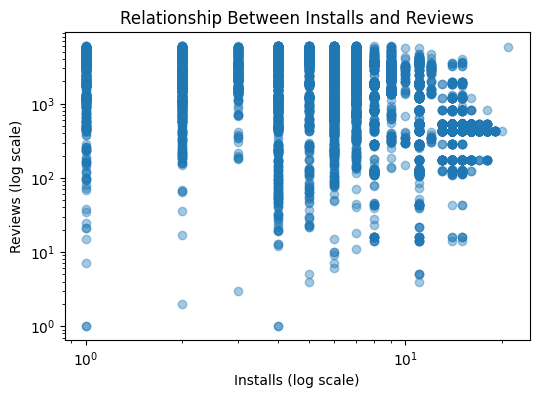

In [2]:
# Visualization (log scale to handle skewness)
plt.figure(figsize=(6, 4))
plt.scatter(df["Installs"], df["Reviews"], alpha=0.4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Installs (log scale)")
plt.ylabel("Reviews (log scale)")
plt.title("Relationship Between Installs and Reviews")
plt.show()


### 🔍 Findings
- Installs and reviews show a **strong positive correlation**.
- The scatter plot reveals a clear upward trend: apps with more installs tend to have more reviews.

### 📌 Interpretation
Apps with higher download counts generally receive more reviews, suggesting that **user engagement scales with reach**. As an app becomes more widely adopted, a larger user base naturally leads to more feedback and reviews.


## ⭐ Bivariate Analysis  
### ❓ Do more-reviewed apps get better ratings?


In [ ]:
# Correlation between number of reviews and rating
df[["Reviews", "Rating"]].corr()


In [ ]:
# Visualization (log scale for reviews)
plt.figure(figsize=(6, 4))
plt.scatter(df["Reviews"], df["Rating"], alpha=0.4)
plt.xscale("log")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Rating")
plt.title("Relationship Between Reviews and Rating")
plt.show()


### 🔍 Findings
- The correlation between reviews and ratings is **very weak (~0.06)**.
- The scatter plot shows no clear upward or downward trend.

### 📌 Interpretation


## 💰 Bivariate Analysis  
### ❓ Does app price affect the number of installs?


In [ ]:
# Correlation between price and installs
df[["Price", "Installs"]].corr()


### 🔍 Findings
- The correlation between **Price** and **Installs** is approximately **-0.01**, which is effectively zero


## 📊 Categorical vs Numerical Analysis

### ❓ Do free apps perform better than paid apps?


In [ ]:
# Aggregate comparison
df.groupby("Type")[["Installs", "Rating", "Reviews"]].mean()
df.groupby("Type")[["Installs", "Rating", "Reviews"]].median()


### 📊 Free vs Paid Apps — Deeper Comparison

To further understand how app type impacts performance, we compare **ratings, installs, and reviews** for free and paid apps using boxplots.


In [ ]:
# Rating distribution
plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="Rating", data=df)
plt.title("Rating Distribution by App Type")
plt.show()


In [ ]:
# Install distribution (log scale)
plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="Installs", data=df)
plt.yscale("log")
plt.title("Installs Distribution by App Type (Log Scale)")
plt.show()


In [ ]:
# Review distribution (log scale)
plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="Reviews", data=df)
plt.yscale("log")
plt.title("Reviews Distribution by App Type (Log Scale)")
plt.show()


### 🔍 Insights
- **Free apps dominate installs and reviews**, even after adjusting for extreme values using log scale.
- **Ratings are high for both free and paid apps**, with paid apps showing slightly more consistency.
- User engagement (installs & reviews) is heavily skewed toward free apps.

### 📌 Conclusion
While paid apps can maintain quality, **free apps achieve far greater reach and engagement**, making them the dominant strategy in the Play Store ecosystem.


### 📂 Category vs Installs

**Question:**  
Which app categories attract the most installs?


In [ ]:
# Average installs per category
df.groupby("Category")["Installs"].mean().sort_values(ascending=False)


In [ ]:
# Visualize top 10 categories by average installs
df.groupby("Category")["Installs"] \
  .mean() \
  .sort_values(ascending=False) \
  .head(10) \
  .plot(kind="barh", figsize=(10,6))

plt.title("Top 10 Categories by Average Installs")
plt.xlabel("Average Installs")
plt.ylabel("Category")
plt.show()


### 🔍 Findings
- **Game**, **Communication**, and **Social** categories have the highest average installs.
- These categories significantly outperform others in terms of user reach.

### 📌 Interpretation
Entertainment and communication-focused apps dominate user demand on the Play Store.  
Users are more likely to download apps that provide **social interaction, gaming, and connectivity**, making these categories highly competitive but also high-reward.


### ⭐ Category vs App Ratings

**Question:**  
Which app categories have the highest-rated apps?


In [ ]:
# Average rating per category
df.groupby("Category")["Rating"].mean().sort_values(ascending=False)


### 🔍 Findings
- Average ratings across categories are consistently high, mostly ranging between **4.0 and 4.4**.
- Categories such as **Events**, **Education**, and **Art & Design** show slightly higher average ratings.

### 📌 Interpretation
User satisfaction does not vary drastically across categories, as most apps are rated positively.  
Category alone is **not a strong differentiator** of app quality.

Because ratings are bounded between **1 and 5**, mean values may mask underlying differences.  
To gain deeper insight, **median ratings and rating distributions** should also be examined.


### ⭐ Category vs App Ratings

**Question:**  
Which app categories have the highest-rated apps?


In [ ]:
# Average rating per category
df.groupby("Category")["Rating"].mean().sort_values(ascending=False)


### 🔍 Findings
- Average ratings across categories are consistently high, mostly ranging between **4.0 and 4.4**.
- Categories such as **Events**, **Education**, and **Art & Design** show slightly higher average ratings.

### 📌 Interpretation
User satisfaction does not vary drastically across categories, as most apps are rated positively.  
Category alone is **not a strong differentiator** of app quality.

Because ratings are bounded between **1 and 5**, mean values may mask underlying differences.  
To gain deeper insight, **median ratings and rating distributions** should also be examined.


### 👥 Content Rating vs App Ratings

**Question:**  
Which audience age group has the highest average app ratings?


In [ ]:
# Average rating by content rating
df.groupby("Content Rating")["Rating"].mean().sort_values(ascending=False)


### 🔍 Findings
- **Adults Only (18+)** apps have the highest average rating (~4.30).
- Ratings across other age groups are very close to each other.

### 📌 Interpretation
Apps targeting mature audiences show slightly higher user satisfaction.  
However, the small differences in average ratings suggest that **content rating does not strongly influence app quality**, and users across all age groups generally report positive experiences.


### ⭐ App Quality vs Installs

**Question:**  
Do higher-quality apps receive more installs?


In [ ]:
# Average installs by app quality
df.groupby("App_Quality")["Installs"].mean()


### 🔍 Findings
- **Good-quality apps** have the highest average installs.
- Average-quality apps follow.
- Bad-quality apps receive the fewest installs.

### 📌 Interpretation
There is a clear positive relationship between **app quality and download volume**.  
Higher-rated apps tend to attract significantly more users, suggesting that **quality and user satisfaction play a key role in app adoption**.


### 💰 App Type vs Popularity Level

**Question:**  
How are free and paid apps distributed across popularity levels?


In [ ]:
# Cross-tabulation of app type and popularity
pd.crosstab(df["Type"], df["Popularity_level"])


### 🔍 Findings
- **Free apps dominate across all popularity levels**.
- Nearly all **highly popular apps are free**.
- **Paid apps** are mostly concentrated in the *Ignored* and *Moderate* categories.
- Paid apps are **rare among highly popular apps**.

### 📌 Interpretation
Free distribution appears to be a major driver of large-scale adoption.  
Price acts as a barrier to entry, significantly reducing the likelihood that paid apps achieve high popularity.


### 📱 Category-wise Popularity Analysis

**Question:**  
Which app categories have a higher proportion of popular apps?


In [ ]:

# Remove invalid category entries (numeric noise)
df = df[~df["Category"].str.contains(r"^\d", na=False)]

# Cross-tabulation
pd.crosstab(df["Category"], df["Popularity_level"])


In [ ]:
# Row-wise normalized proportions
pd.crosstab(
    df["Category"],
    df["Popularity_level"],
    normalize="index"
)


In [ ]:
# Visualize proportion of popular apps by category
pd.crosstab(
    df["Category"],
    df["Popularity_level"],
    normalize="index"
)["Popular"] \
.sort_values(ascending=False) \
.plot(
    kind="bar",
    figsize=(12,6),
    title="Proportion of Popular Apps by Category"
)

plt.ylabel("Proportion of Popular Apps")
plt.xlabel("App Category")
plt.show()


### 🔍 Findings
- Categories such as **Game, Communication, and Social** show a higher proportion of popular apps.
- Utility-heavy or niche categories tend to have a lower share of popular apps.
- Popularity is not evenly distributed across categories.

### 📌 Interpretation
User demand is strongly concentrated in **entertainment and communication-focused categories**.  
Apps in these categories have a higher chance of reaching large audiences, while other categories face tougher visibility and adoption challenges.


### ⭐ App Quality vs Popularity

**Question:**  
Does app quality influence popularity level?


In [ ]:
# Cross-tabulation: App Quality vs Popularity Level
pd.crosstab(df["App_Quality"], df["Popularity_level"])


In [ ]:
# Row-wise normalized proportions
pd.crosstab(
    df["App_Quality"],
    df["Popularity_level"],
    normalize="index"
)


### 🔍 Findings
- Only **~2%** of **Bad-quality** apps reach high popularity.
- Around **~16%** of **Average-quality** apps become popular.
- Nearly **~28%** of **Good-quality** apps achieve high popularity.

### 📌 Interpretation
App quality has a **strong positive influence** on popularity.  
Higher-quality apps are significantly more likely to reach large user bases, while low-quality apps rarely become popular. This highlights the importance of product quality as a key driver of market success.


❓ Do free apps become popular even if their quality is only average?

In [ ]:
pd.crosstab(
    [df["Type"], df["App_Quality"]],
    df["Popularity_level"],
    normalize=True
)


Free apps are more likely to become popular even when their quality is only average.
This indicates that pricing strategy can partially offset moderate app quality, helping free apps reach wider adoption.

❓ Which categories benefit most from being free?

In [ ]:
# Popularity distribution by Category and Type
ct = pd.crosstab(
    [df["Category"], df["Type"]],
    df["Popularity_level"],
    normalize="index"
)

# Extract popularity rate
popular_rates = ct["Popular"]

# Compare Free vs Paid apps
popular_df = popular_rates.unstack()

# Measure free pricing advantage
popular_df["Free_Benefit"] = popular_df["Free"] - popular_df["Paid"]

popular_df.sort_values("Free_Benefit", ascending=False)


Free apps show a clear popularity advantage—especially in mass-market categories—demonstrating that pricing strategy can significantly boost adoption even when app quality is only average.


### 💰 Ratings of Popular Paid vs Free Apps

**Question:**  
Are popular paid apps rated higher than popular free apps?


In [ ]:
df.pivot_table(
    values="Rating",
    index="Popularity_level",
    columns="Type",
    aggfunc="mean"
)


In [ ]:
# Visualize
df.pivot_table(
    values="Rating",
    index="Popularity_level",
    columns="Type",
    aggfunc="mean"
).plot(
    kind="bar",
    figsize=(8,5),
    title="Average Rating by Popularity Level and App Type",
    ylabel="Average Rating"
)


### 🔍 Findings
- Among **popular apps**, paid apps show a **slightly higher average rating** than free apps.
- The rating difference is **small**, indicating that popularity does not strongly depend on being paid or free once an app succeeds.

### 📌 Interpretation
While paid


In [ ]:
# 📊 Average Rating by Category and Popularity Level

# Create pivot table
pivot = df.pivot_table(
    values="Rating",
    index="Category",
    columns="Popularity_level",
    aggfunc="mean"
)

# Display pivot table
pivot


In [ ]:
# 📈 Visualize average ratings by category and popularity level

pivot.plot(
    kind="bar",
    figsize=(14, 6),
    title="Average App Rating by Category and Popularity Level",
    ylabel="Average Rating"
)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 📌 Insight
Across most categories, **popular apps tend to have higher average ratings** than ignored or moderately popular apps.  
This suggests that while high ratings do not guarantee popularity, **sustained popularity is rarely achieved without strong user satisfaction**.


In [ ]:
# ❓ Are lightweight popular apps rated better than heavy popular apps?

# Create size groups
df["Size_Group"] = np.where(df["Size_MB"] < 20, "Light", "Heavy")

# Cross-tabulation of Size, Popularity, and App Quality (percentage)
size_popularity_quality = (
    pd.crosstab(
        [df["Size_Group"], df["Popularity_level"]],
        df["App_Quality"],
        normalize="index"
    ) * 100
)

size_popularity_quality


### 📌 Insight
For popular apps, both lightweight and heavy apps are overwhelmingly **good quality (≈85–89%)**.  
App size has **minimal influence on popularity or perceived quality** once an app is popular.  
This indicates that **quality matters far more than size** in driving successful, popular apps.


In [ ]:
# ❓ Do apps supporting older Android versions achieve wider reach?

# Group apps by Android version support
df["Android_Group"] = np.where(
    df["Android_Ver_Min"] <= 5,
    "Older Android",
    "Newer Android"
)

# Compare average installs
df.groupby("Android_Group")["Installs"].mean()


In [ ]:
# Compare median installs (more robust)
df.groupby("Android_Group")["Installs"].median()


In [ ]:
# ❓ Do apps supporting older Android versions achieve wider reach?

# Create Android compatibility groups
df["Android_Group"] = np.where(
    df["Android_Ver_Min"] <= 5,
    "Older Android",
    "Newer Android"
)

# Compare average installs
df.groupby("Android_Group")["Installs"].mean()


### 📌 Insight
Apps that support **older Android versions** have a significantly higher average number of installs.  
This suggests that broader Android compatibility increases potential reach, especially in regions where older devices are still common.

**Note:** Using median installs can further validate this result by reducing the influence of extremely popular apps.


🔹 Phase 3: Reviews Dataset Analysis

   Load the Reviews Dataset

In [ ]:
import pandas as pd
import numpy as np

reviews_df = pd.read_csv("../data/review_data.csv")

# Basic checks
reviews_df.shape
reviews_df.info()
reviews_df.head()


Initial Data Quality Check

In [ ]:
# Missing values
reviews_df.isnull().sum()

# Duplicate rows
reviews_df.duplicated().sum()


🧹 Data Cleaning — Reviews Dataset


In [ ]:
# Remove rows with missing values
reviews_clean = reviews_df.dropna()

# Verify missing values
reviews_clean.isnull().sum()


reviews_clean.info()


Remove Duplicate Reviews

In [ ]:
# Remove duplicate rows
reviews_clean = reviews_clean.drop_duplicates()

# Check duplicates
reviews_clean.duplicated().sum()


In [ ]:
# Reset index after cleaning
reviews_clean.reset_index(drop=True, inplace=True)

reviews_clean.info()

The index was reset after cleaning to maintain a clean and sequential dataframe structure.


Text Normalization

In [ ]:
# Convert reviews to lowercase
reviews_clean["Translated_Review"] = (
    reviews_clean["Translated_Review"].str.lower()
)


6️⃣ Sentiment Statistics Overview

In [ ]:
reviews_clean[["Sentiment_Polarity", "Sentiment_Subjectivity"]].describe()


- **Sentiment Polarity** ranges from -1 (negative) to +1 (positive), with a positive mean indicating overall favorable sentiment.
- **Sentiment Subjectivity** values suggest that most reviews contain a mix of personal opinion and factual information.


❓ What is the distribution of sentiment in user reviews?

In [ ]:
# Sentiment distribution (counts)
reviews_clean["Sentiment"].value_counts()

# Sentiment distribution (percentage)
reviews_clean["Sentiment"].value_counts(normalize=True) * 100


In [ ]:
# Visualization
reviews_clean["Sentiment"].value_counts().plot(
    kind="bar",
    title="Sentiment Distribution of User Reviews"
)
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


Most user reviews express **positive sentiment**, followed by neutral reviews.
Negative reviews make up a smaller proportion, indicating generally favorable user perception of apps on the Play Store.


❓ How are sentiment polarity scores distributed?

In [ ]:
# Statistical Summary

reviews_clean["Sentiment_Polarity"].describe()

# Visualization

plt.hist(reviews_clean["Sentiment_Polarity"], bins=30)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity Score")
plt.ylabel("Frequency")
plt.show()



Sentiment polarity values range from -1 (strongly negative) to +1 (strongly positive.
The distribution is skewed toward positive values, confirming that most reviews express positive opinions.
Extreme negative and positive sentiments exist but are relatively rare.


# ❓ Question 3: How subjective are user reviews?

In [ ]:

reviews_clean["Sentiment_Subjectivity"].describe()

reviews_clean["Sentiment_Subjectivity"].hist(bins=30)

# ❓ Question 4: How many reviews does each app receive? (Categorical frequency)

In [ ]:


reviews_per_app = reviews_clean["App"].value_counts()
reviews_per_app.describe()

The number of reviews per app ranges from 1 to 130, with an average of about 34 reviews per app. The distribution shows moderate variability, indicating that while most apps receive a similar number of reviews, a small subset attracts relatively higher engagement. Unlike typical app-store data, extreme review concentration is not observed in this dataset.

# ❓ Question 5: Are there extreme sentiment values (outliers)?

In [ ]:


reviews_clean["Sentiment_Polarity"].describe()
reviews_clean["Sentiment_Polarity"].plot(kind="box")

User reviews are generally positive, but strong emotional outliers exist and should be retained for analysis.

🔗 Merging Apps & Reviews Data
❓ How many apps do not have associated user reviews?

In [ ]:
merged_df = df.merge(
    reviews_clean,
    on="App",
    how="left"
)


In [ ]:
# Missing Sentiment After Merge

merged_df["Sentiment_Polarity"].isna().mean() * 100


Approximately **18.7% of apps have no associated user reviews**, resulting in missing sentiment polarity values after merging.

These apps were retained in the dataset due to the **left join strategy**, ensuring no loss of app-level information.  
However, apps without reviews were **excluded from sentiment-based analyses**, as sentiment metrics are unavailable for them.


📊 Impact of Reviews on App Performance
❓ Are apps with reviews different from apps without reviews?

In [ ]:
# Create a dataframe only for sentiment-based analysis
sentiment_df = merged_df.dropna(subset=["Sentiment_Polarity"])

# Flag apps that have at least one review
merged_df["Has_Review"] = merged_df["Sentiment_Polarity"].notna()


In [ ]:
# 📈 Compare Installs by Review Presence
merged_df.groupby("Has_Review")["Installs"].mean()


In [ ]:
# ⭐ Compare Ratings by Review Presence
merged_df.groupby("Has_Review")["Rating"].mean()


Apps that have user reviews show **significantly higher average installs** and **slightly higher average ratings** compared to apps without reviews.

This suggests that user reviews are strongly associated with an app’s **visibility, popularity, and perceived credibility**. Apps without reviews tend to have lower reach and marginally lower user trust.


⭐ Sentiment Polarity vs App Rating
❓ Does higher sentiment polarity relate to higher ratings?

In [ ]:
# Correlation Analysis
merged_df[["Sentiment_Polarity", "Rating"]].corr()


The correlation between **sentiment polarity** and **app rating** is very weak, indicating no strong linear relationship.

This suggests that:
- Apps with more positive review sentiment do **not necessarily** have higher ratings.
- Ratings reflect overall user evaluation, while sentiment polarity captures emotional tone of individual reviews.

Therefore, sentiment polarity should be used as a **complementary signal**, not a substitute for ratings.


📝 Review Length vs Sentiment Subjectivity
❓ Are longer reviews more subjective?

In [ ]:
merged_df["Review_Length"] = (
    merged_df["Translated_Review"]
    .astype(str)
    .apply(len)
)


In [ ]:
merged_df[["Review_Length", "Sentiment_Subjectivity"]].corr()


In [ ]:
# Visualization
sns.scatterplot(
    data=merged_df,
    x="Review_Length",
    y="Sentiment_Subjectivity",
    alpha=0.3
)
plt.title("Review Length vs Sentiment Subjectivity")
plt.xlabel("Review Length (characters)")
plt.ylabel("Sentiment Subjectivity")
plt.show()


The correlation between **review length** and **sentiment subjectivity** is extremely weak (≈ 0.02).

This indicates that:
- Longer reviews are not necessarily more opinion-based.
- Strong personal opinions can be expressed in both short and long reviews.
- Review length does not meaningfully influence how subjective a review is.


⭐ Sentiment vs Rating Across Popularity Levels
❓ Does sentiment matter more for popular apps than unpopular ones?

In [ ]:
merged_df.groupby("Popularity_level")[["Sentiment_Polarity", "Rating"]].corr()


The relationship between **sentiment polarity** and **app rating** is weak across all popularity levels.

- The correlation is slightly higher for **Ignored** and **Moderate** apps.
- For **Popular** apps, the relationship becomes very weak.

This suggests that ratings of highly popular apps are less influenced by individual review sentiment.
